# Homework 4

- Execute the below code, then answer the numbered questions.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [2]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


In [3]:
X.columns

Index(['make', 'transmission', 'state', 'condition', 'odometer',
       'auction_value'],
      dtype='object')

## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [4]:
numerical_features = ['condition','odometer','auction_value'] 
categorical_features = ['make','transmission','state']

## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [5]:
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
numerical_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])
set_config(display='diagram')
numerical_pipeline

Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median')),
                ('standardize_num', StandardScaler())])

In [6]:
numerical_pipeline

Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median')),
                ('standardize_num', StandardScaler())])

## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [7]:
from sklearn.preprocessing import OneHotEncoder
categorical_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])
set_config(display='diagram')
categorical_pipeline

Pipeline(steps=[('impute_missing_cats',
                 SimpleImputer(strategy='most_frequent')),
                ('create_dummies_cats',
                 OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [8]:
X_train_transformed = categorical_pipeline.fit_transform(X_train[['make','transmission','state']])

In [9]:
# Validating if the all the columns are numeric
assert np.all(np.isfinite(X_train_transformed.todense()))

# Determined the number of columns in the transformed data
num_cols_transformed = X_train_transformed.shape[1]
num_cols_transformed

41

## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [10]:
from sklearn.compose import ColumnTransformer
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', numerical_pipeline, numerical_features),
                                                      ('create_dummies', categorical_pipeline, categorical_features)])

processing_pipeline

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['condition', 'odometer', 'auction_value']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['make', 'transmission', 'state'])])

In [11]:
processing_pipeline.fit(X_train)
transformed_X_train = processing_pipeline.transform(X_train)

# To validate if the data contains missing values
assert np.isnan(transformed_X_train.todense()).sum() == 0, "Data contains missing values after transformation"

# To validate number of columns
assert transformed_X_train.shape[1] == len(numerical_features) + categorical_pipeline.named_steps['create_dummies_cats'].get_feature_names_out().shape[0], "Data has incorrect number of columns after transformation"

## Question 5: Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [12]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), 
                              ('lm', LinearRegression())
                             ])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['make', 'transmission',
                                                   'state'])])),
                ('lm', LinearRegression())])

In [13]:
predictions = modeling_pipeline.predict(X_test)

In [14]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
r2

0.8838274416405266

## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

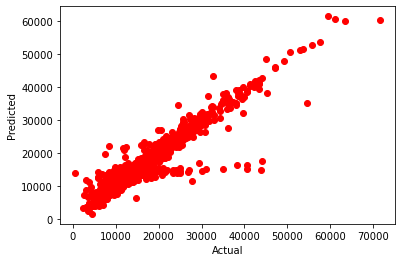

In [15]:
import matplotlib.pyplot as plt

plt.plot(y_test,predictions, 'ro')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

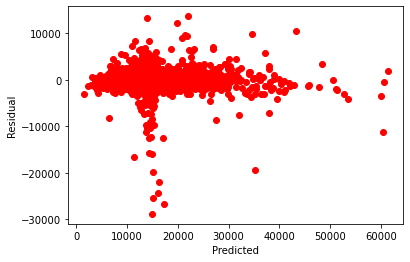

In [16]:
plt.plot(predictions, predictions - y_test, 'ro')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.show()

 - From above two plots we can say that the model has not perfored well for a portion data whose selling price is between 20K & 50K
 - The model has predicted less value than the actual selling price of the vehicle which resulted to negetive residue


## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [17]:
from sklearn.linear_model import Ridge
modified_pipeline = Pipeline([('data_processing', processing_pipeline), 
                              ('lm', Ridge(alpha=100.0))
                             ])
modified_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['make', 'transmission',
                                                   'state'])])),
                ('lm', Ridge(alpha=100.0))])

In [18]:
new_predictions = modified_pipeline.predict(X_test)

In [19]:
from sklearn.metrics import r2_score
new_r2 = r2_score(y_test, new_predictions)
new_r2

0.8824295262286399

- There is only a little change in the r2 values after applying ridge regression
- The value changed from 0.883 to 0.882